# Assignment 11: Adversarial Training

In this assignment, we will show that adversarial training provides stability against adversarial attacks for the MNIST dataset.
We will compare three different types of training procedures:

1. Train with only the original samples
2. Train with original samples and samples with added random noise
3. Train with original samples and adversarial samples generated by Fast Gradient Sign (FGS) method

Note that the results of this experiment might not translate well to other datasets.

## Dataset and Model

For our experiments, we come back to the dataset and the model that we have used before.
Particularly, we train and test our methods on the MNIST dataset, using a very similar deep network structure as in previous exercises.

### Task 1: Dataset

Instantiate the training and validation set splits of MNIST, including data loaders. Select appropriate batch sizes for training and validation sets.

In [34]:
import torch
import torchvision

transform = torchvision.transforms.ToTensor()

# training set and data loader
train_set = torchvision.datasets.MNIST(root="/data/MNIST", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=32)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(root="/data/MNIST", train=False, download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=False, batch_size=100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Task 2: Classification Network

Use a similar small-scale network as we have done in Assignment 8.

Implement a network with two convolutional and two fully-connected layers.
The first convolutional layer has kernel size $7 \times 7$, stride $=1$, and padding $=0$. The second one has kernel size $5\times5$, stride $=1$, and padding $=2$. Both are followed by a $2\times2$ maximum pooling and a ReLU activation.

Select appropriate numbers of input and output channels for the convolutions.
The first fully-connected layer reduces the feature map to a certain size $K$, which can be selected freely, while the second layer produces $O=10$ logits.

Note:

* You can also build your network with `torch.nn.Sequential`.

In [35]:
class Network(torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    self.build = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=(7, 7), stride=1, padding=0),
      torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      torch.nn.ReLU(),
      torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=(5, 5), stride=1, padding=2),
      torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
      torch.nn.ReLU(),
      torch.nn.Flatten(),
      torch.nn.Linear((5**2) * Q2, K),
      torch.nn.Linear(K, O)
    )

  def forward(self,x):
    return self.build(x)

## Image Manipulation

We implement three different ways to manipulate the images for generating additional training data.
The first way is to compute adversarial samples using the Fast Gradient Sign method.
Here, we want to adapt the image such that we maximize the loss between the network output and the target.
For this purpose, we need to compute the FGS adversarial samples by using the derivative of the loss with respect to the image:

$$\mathbf X_{\mathrm{FGS}} = \mathbf X + \alpha \mathrm{sign}(\nabla_{\mathbf X})$$

with

$$\nabla_{\mathbf X} = \frac{\partial \mathcal J_{CCE}}{\partial \mathbf X} $$

Then we need to implement the Fast Gradient Value method,

$$\mathbf X_{\mathrm{FGV}} = \mathbf X + \alpha \frac{\nabla_{\mathbf X}} {\mathrm{max} |\nabla_{\mathbf X}|}$$

and the generated adversarial samples will only be used in the validation, not training, to check whether the network trained with FGS is also robust to FGV samples.

The third type of manipulation is to add simple noise that represents the same type and magnitude of manipulations as FGS, i.e., we want our noisy image to be:

$$\mathbf X_{\mathrm{noise}} = \mathbf X + \alpha \{-1,1\}^{D\times E}$$

where $D$ and $E$ are the width and the height of the original image. $-1$ and $1$ are sampled with the same probability, and independently for each pixel. In all three methods, $\alpha$ controls the magnitude of the added part.

In order to represent actual images, we will restrict the pixel values of both $\mathbf X_{\mathrm{FGS}}$, $\mathbf X_{\mathrm{FGV}}$, and $\mathbf X_{\mathrm{noise}}$ to be in the range $[0,1]$ by clipping any value that is outside that range.



### Task 3: Fast Gradient Sign

Implement a function that computes the gradient of the given loss function w.r.t. the input.
Compute the adversarial sample using the above definition of $\mathbf X_{\mathrm{FGS}}$, and restrict the output values to be in the range $[0,1]$.

Note that this function will be used with batches of samples.


In [36]:
def FGS(x, t, network, loss, alpha=0.3):
  x, t = x.to(device), t.to(device)
  # tell autograd that we need the gradient for the input
  x.requires_grad_()
  # forward input
  z = network(x)
  # compute loss and gradient
  J = loss(z, t)
  J.backward()

  # get the gradient
  gradient = x.grad
  # create FGS adversarial sample
  adversarial_sample = x + alpha * torch.sign(gradient)

  return torch.clamp(adversarial_sample, 0, 1)

### Task 4: Fast Gradient Value

Implement a function that computes the gradient of the given loss function w.r.t. the input.
Compute the adversarial sample using the above definition of $\mathbf X_{\mathrm{FGV}}$, and restrict the output values to be in the range $[0,1]$.

Note that this function will be used with batches of samples.

In [37]:
def FGV(x, t, network, loss, alpha=0.6):
  x, t = x.to(device), t.to(device)
  # tell autograd that we need the gradient for the input
  x.requires_grad_()
  # forward input
  z = network(x)
  # compute loss and gradient
  J = loss(z, t)
  J.backward()

  # get the gradient
  gradient = x.grad
  # create FGV adversarial sample
  adversarial_sample = x + alpha * (gradient / torch.amax(torch.abs(gradient), dim=[1, 2, 3], keepdim=True))

  return torch.clamp(adversarial_sample, 0, 1)

### Task 5: Random Noise

Implement a function that computes the noisy sample according to the definition of $\mathbf X_{\mathrm{noise}}$ shown above, and restricts the output values to be in the range $[0,1]$.


Note that this function will also be used with batches of samples.

In [38]:
def noise(x, alpha=0.3):
  x = x.to(device)
  # generate noise
  noise = torch.rand(x.size(), device=device) * 2 - 1
  # Add noise and clamp
  noisy_sample = x + alpha * noise

  return torch.clamp(noisy_sample, 0, 1)

### Test 1: Adversarial Samples and Noisy Samples

Verify that the generated $\mathbf X_{\mathrm{FGS}}$, $\mathbf X_{\mathrm{FGV}}$, and $\mathbf X_{\mathrm{noise}}$ have the same shape as $\mathbf X$ and all pixels are ranged in $[0,1]$.

Visualize $\mathbf X$, $\mathbf X_{\mathrm{FGS}}$, $\mathbf X_{\mathrm{FGV}}$, and $\mathbf X_{\mathrm{noise}}$.

In [39]:
# create network
network = Network(32,64,10,10).to(device)

loss = torch.nn.CrossEntropyLoss()

# use first validation batch
x, t = next(iter(validation_loader))

# Check the noisy samples: correct shape and range
x_noise = noise(x.to(device), alpha=0.3)
assert x_noise.shape == x.shape
assert torch.all(x_noise >= 0) and torch.all(x_noise <= 1)

# Check the generated adversarial samples: correct shape and range
x_fgs = FGS(x.to(device), t.to(device), network, loss, alpha=0.3)
assert x_fgs.shape == x.shape
assert torch.all(x_fgs >= 0) and torch.all(x_fgs <= 1)

x_fgv = FGV(x.to(device), t.to(device), network, loss, alpha=0.6)
assert x_fgv.shape == x.shape
assert torch.all(x_fgv >= 0) and torch.all(x_fgv <= 1)

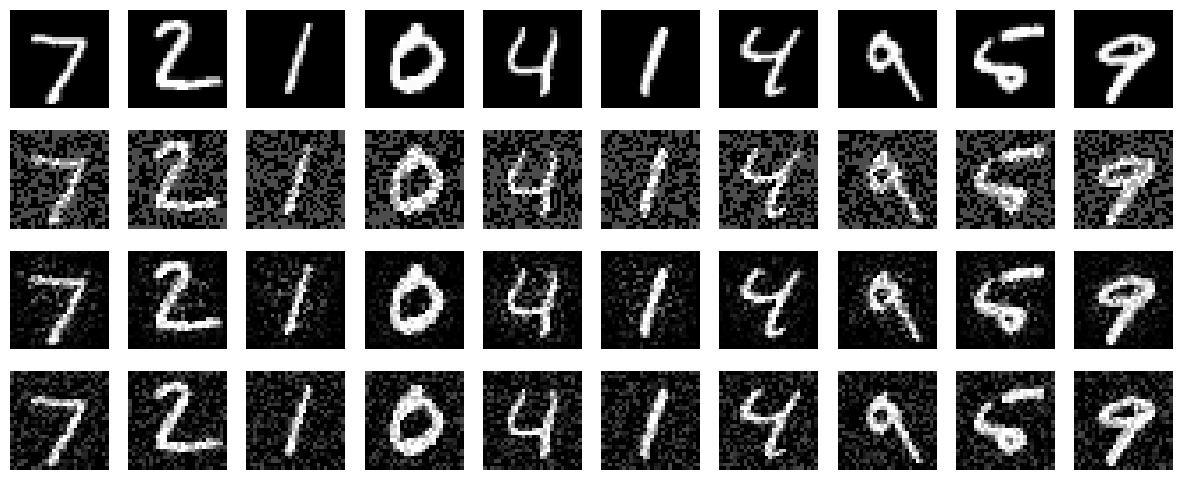

In [40]:
samples = [x.cpu().detach().numpy(), x_fgs.cpu().detach().numpy(), x_fgv.cpu().detach().numpy(), x_noise.cpu().detach().numpy()]

# plot images
from matplotlib import pyplot
pyplot.rcParams['image.cmap'] = 'gray'

fig, axes = pyplot.subplots(nrows=4, ncols=10, figsize=(15, 6))

for i in range(4):
    for j in range(10):
      axes[i][j].imshow(samples[i][j].squeeze())
      axes[i][j].axis("off")

## Training and Evaluation

We will implement three different variations of the training procedure, which will be combined into one function.
In all three variations, we will iterate over all batches in the training set and train the network with standard categorical cross-entropy loss.
Variation 1 will only perform the **standard training**.
Variation 2 will generate **FGS adversarial samples** for all images in the batch, and **train with the adversarial samples** while assigning the original targets.
In variation 3, we will also train with additional data, but instead of generating adversarial samples, we will just **add noise** to our images.

For evaluation, we will compute three different measures.
First, we compute the **classification accuracy** of the network on the clean, unperturbed images of the validation set.
Second, we will create adversarial samples via our FGS technique for **all correctly classified validation set samples** and assess how many of these **adversarial samples are classified as their original class** by the network.
Then, we will repeat the same procedure for **FGV adversarial samples**.

### Task 6: Training Loop

For a given network, loss and optimizer, implement a function that trains the network for one epoch on the training data.
If desired by the `add_additional_samples` parameter, implement variation 1, 2, or 3.
Perform update steps where they fit.


In [41]:
from tqdm.notebook import tqdm

def training_loop(network, loss, optimizer, add_additional_samples=None, alpha=0.3):
  network = network.to(device)
  description = f'training {"default" if add_additional_samples is None else add_additional_samples}'
  for x, t in tqdm(train_loader, desc=description, colour='purple', leave=False):
    optimizer.zero_grad()
    x, t = x.to(device), t.to(device)
    # compute output for current batch
    z = network(x)
    # compute loss
    J = loss(z, t)
    # compute gradient
    J.backward()

    if add_additional_samples is not None:
      # compute modified samples for batch
      if add_additional_samples == "FGS":
        # create FGS adversarial samples
        x_hat = FGS(x, t, network, loss, alpha)
      else:
        # create noisy samples
        x_hat = noise(x, alpha)

      # compute output for modified samples
      z_hat = network(x_hat)
      # compute loss on modified samples
      J = loss(z_hat, t)
      # compute gradient
      J.backward()

    optimizer.step()

### Task 7: Validation Loop


For a given network and loss function, iterate over the validation set and compute the classification accuracy on the original validation set samples.

For each batch, select the correctly classified images. For these, generate two types of adversarial samples, using FGS and FGV defined above, respectively.

Finally, compute how many of the adversarial samples are still classified as the original class by the network.



In [42]:
def validation_loop(network, loss, add_additional_samples=None, alpha_fgs=0.3, alpha_fgv=0.6):
  network = network.to(device)
  correct_clean_count, correct_fgs_count, correct_fgv_count = 0, 0, 0

  description = f'validating {"default" if add_additional_samples is None else add_additional_samples}'
  # iterate over validation set samples
  for x, t in tqdm(validation_loader, desc=description, colour='orange', leave=False):
    with torch.no_grad():
      x, t = x.to(device), t.to(device)
      # classify original samples
      z = network(x)

      # compute classification accuracy on original samples
      preds = torch.argmax(z, dim=1)
      correct_clean_count += (preds == t).sum().item()

    # select the correctly classified samples
    correct_indices = (preds == t)
    x_correct = x[correct_indices]
    t_correct = t[correct_indices]

    # create adversarial samples using FGS and FGV
    x_attack_fgs = FGS(x_correct, t_correct, network, loss, alpha_fgs)
    x_attack_fgv = FGV(x_correct, t_correct, network, loss, alpha_fgv)

    # check how many are correctly classified
    with torch.no_grad():
      # classify adversarial samples
      z_attack_fgs = network(x_attack_fgs)
      z_attack_fgv = network(x_attack_fgv)

      # compute classification accuracy on adversarial samples
      correct_fgs_count += (torch.argmax(z_attack_fgs, dim=1) == t_correct).sum().item()
      correct_fgv_count += (torch.argmax(z_attack_fgv, dim=1) == t_correct).sum().item()

  # compute clean and adversarial accuracies and return them
  clean_accuracy = correct_clean_count / len(validation_loader.dataset)
  fgs_accuracy = (correct_fgs_count / correct_clean_count) if correct_clean_count > 0 else 0
  fgv_accuracy = (correct_fgv_count / correct_clean_count) if correct_clean_count > 0 else 0
  return clean_accuracy, fgs_accuracy, fgv_accuracy

### Task 8: Training of Three Networks

Instantiate three networks, one to train with only clean samples, one to additionally train with FGS adversarial samples, and one to additionally train with noise.

Instantiate corresponding optimizers that train these networks. Make use of SGD with an appropriate learning rate $\eta$ and categorical cross-entropy loss.

Train each of the three networks for 10 epochs (or more) using their specific data extension.

Compute and store the validation set accuracy on the clean, FGS adversarial samples, and FGV adversarial samples -- note that adversarial samples will be generated for each network separately -- after each training epoch. So the training time is extended as compared to normal training since the creation of adversarial samples requires time.

Remember to setup a higher $\alpha$ when generating FGV samples (at least $\times 2$ to the FGS $\alpha$)

In [43]:
number_networks = 3
# define one network for each training procedure
networks = [Network(32, 64, 10, 10) for _ in range(number_networks)]
# define optimizer
optimizers = [torch.optim.SGD(
  params=networks[i].parameters(),
  lr=0.005,
  momentum=0.8
) for i in range(number_networks)]

# define loss function and alpha
loss = torch.nn.CrossEntropyLoss()
alpha = 0.3

# store accuracies on clean and adversarial samples for the three cases
clean_accuracies = [[] for _ in range(number_networks)]
fgs_accuracies = [[] for _ in range(number_networks)]
fgv_accuracies = [[] for _ in range(number_networks)]

# store network types
data_extensions = [None, "noise", "FGS"]

# iterate over 10 epochs (or more)
for epoch in tqdm(range(10), desc='epoch'):
  for idx, (network, optimizer, data_extension) in enumerate(zip(networks, optimizers, data_extensions)):
    # perform training loop
    training_loop(network, loss, optimizer, data_extension, alpha=alpha)
    # compute and store validation set accuracies
    clean, fgs, fgv = validation_loop(network, loss, data_extension, alpha_fgs=alpha, alpha_fgv=alpha*2)
    clean_accuracies[idx].append(clean)
    fgs_accuracies[idx].append(fgs)
    fgv_accuracies[idx].append(fgv)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

training default:   0%|          | 0/1875 [00:00<?, ?it/s]

validating default:   0%|          | 0/100 [00:00<?, ?it/s]

training noise:   0%|          | 0/1875 [00:00<?, ?it/s]

validating noise:   0%|          | 0/100 [00:00<?, ?it/s]

training FGS:   0%|          | 0/1875 [00:00<?, ?it/s]

validating FGS:   0%|          | 0/100 [00:00<?, ?it/s]

### Task 9: Plotting of Accuracies

Generate three plots.

In the first plot, compare the accuracies on the clean images of the validation set over the 10 epochs. (Plot clean accuracies)

In the second plot, compare the stability of the networks w.r.t. FGS adversarial samples, i.e., how many FGS adversarial samples can change the classification of the network. (Plot FGS adversarial accuracies)

In the third plot, compare the stability of the networks w.r.t. FGV adversarial samples, i.e., how many FGV adversarial samples can change the classification of the network. (Plot FGV adversarial accuracies)

Exemplary plots can be found in the slides.


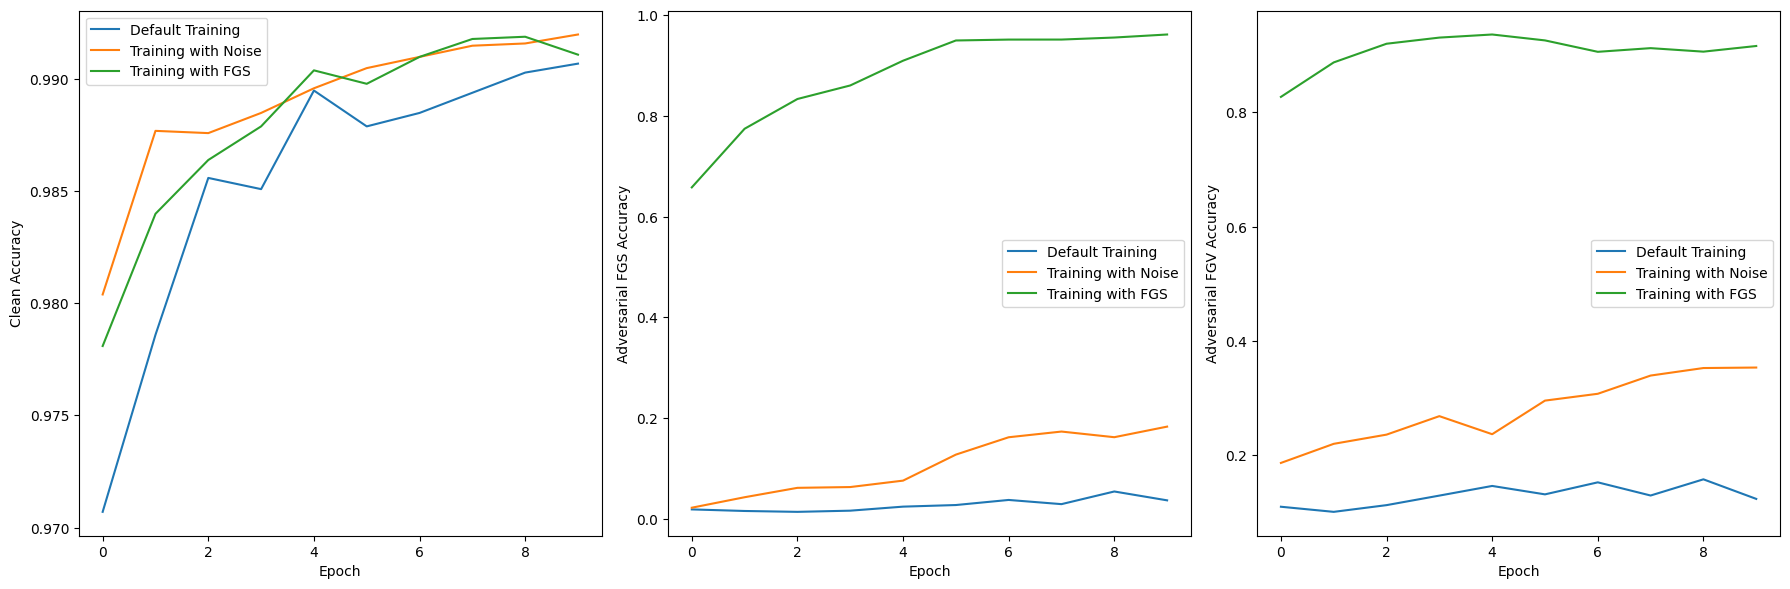

In [44]:
pyplot.figure(figsize=(18, 6))

all_accuracies = [clean_accuracies, fgs_accuracies, fgv_accuracies]
line_labels = ['Default Training', 'Training with Noise', 'Training with FGS']
ylabels = ['Clean Accuracy', 'Adversarial FGS Accuracy', 'Adversarial FGV Accuracy']

for plot_idx, (accuracies, ylabel) in enumerate(zip(all_accuracies, ylabels)):
  pyplot.subplot(1, 3, plot_idx+1)
  for idx, accuracy in enumerate(accuracies):
    pyplot.plot(accuracy, label=line_labels[idx])
  pyplot.xlabel('Epoch')
  pyplot.ylabel(ylabel)
  pyplot.legend()

pyplot.tight_layout()